# Exploratory Data Analysis (EDA) for Twitter Political Dataset
This notebook explains in detail the various EDA techniques explored for preparing the dataset for sentiment analysis. The steps we've taken have been broken into stages (represented as `<stage number> - <stage name>`).

# 1 - Getting Started
In this stage, we:

a. Install and import all dependencies required for the challenge.

b. Initialize Spark Session.

c. Read and cache dataset.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/PB02-main 2/notebooks'

/content/drive/MyDrive/PB02-main 2/notebooks


In [3]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=66f51538b74909cec94bbba2c6be7fcd28ae65a0611b6036a73ed323a17b949c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
!pip install textblob


In [31]:
%matplotlib inline
from src.jobs.spark_etl import extract
from src.utils.spark import initSparkSession
from src.utils.text import clean_text
import src.utils.constants as constants
import pyspark.sql.functions as sql_f
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, NGram, VectorAssembler, SQLTransformer, HashingTF, IDF, StringIndexer, ChiSqSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import nltk
import re
nltk.download('stopwords')
from pyspark.sql.functions import col, explode
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
#Spark Session
sparkSession = initSparkSession(appName='EDA')
sparkSession

In [33]:
df = extract(sparkSession)
df.cache()

DataFrame[created_at: timestamp, tweet_id: string, tweet: string, likes: float, retweet_count: float, source: string, user_id: string, user_name: string, user_screen_name: string, user_description: string, user_join_date: timestamp, user_followers_count: float, user_location: string, lat: double, long: double, city: string, country: string, continent: string, state: string, state_code: string, collected_at: timestamp, candidate: string]

# 2 - Descriptive Statistics

In [35]:
df.createOrReplaceTempView("politicalTweets")
df.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: float (nullable = true)
 |-- retweet_count: float (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: timestamp (nullable = true)
 |-- user_followers_count: float (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: timestamp (nullable = true)
 |-- candidate: string (nullable = false)



In [36]:
# visualize tweets matching United States country patterns
sparkSession.sql("""
    SELECT country, COUNT(country) count
        FROM politicalTweets
        WHERE country LIKE 'United S%'
        OR country LIKE '%USA%'
        GROUP BY country
        ORDER BY count DESC
""").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|country                                                                                                                                                     |count |
+------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|United States of America                                                                                                                                    |316181|
|United States                                                                                                                                               |59192 |
|Wilmington, DE... in the great country of USA!                                                                                                              |31    |
|Flo

In [10]:
# visualizing invalid timestamps
df.createOrReplaceTempView("politicalTweets")
sparkSession.sql("""
    SELECT tweet_id,
            user_join_date
            FROM politicalTweets
            WHERE user_join_date > '2022-05-05'
""").show(truncate=False)

+--------+---------------------+
|tweet_id|user_join_date       |
+--------+---------------------+
|0.0     |+93720-01-01 00:00:00|
|0.0     |7866-01-01 00:00:00  |
|0.0     |+93720-01-01 00:00:00|
|0.0     |+62208-01-01 00:00:00|
|1.0     |+94590-01-01 00:00:00|
|1.0     |+11550-01-01 00:00:00|
|0.0     |+90272-01-01 00:00:00|
|0.0     |+90272-01-01 00:00:00|
|0.0     |+20815-01-01 00:00:00|
|1.0     |+20815-01-01 00:00:00|
+--------+---------------------+



In [11]:
#We see from the above that there's a correlation between corrupt tweet IDs and corrupt data
#Let's see if there exists more records with corrupted tweet ID
df.createOrReplaceTempView("politicalTweets")
sparkSession.sql("""
    SELECT tweet_id,
            tweet,
            user_join_date
            FROM politicalTweets
            WHERE tweet_id = 0 or tweet_id = 1
""").show(32618, truncate=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
df = df.where(df.user_join_date < '2022-05-05')
df = df.where(sql_f.col('user_join_date').isNotNull())

In [13]:
# we see from the above that there's a correlation between corrupt tweet IDs and corrupt data
# let's see if there exists more records with corrupted tweet ID
df.createOrReplaceTempView("politicalTweets")
sparkSession.sql("""
    SELECT tweet_id,
            tweet,
            user_join_date
            FROM politicalTweets
            WHERE tweet_id = 0 or tweet_id = 1
""").show(32618, truncate=False)

+--------+-----+-------------------+
|tweet_id|tweet|user_join_date     |
+--------+-----+-------------------+
|0.0     |0.0  |2017-07-27 19:20:51|
|0.0     |0.0  |2017-07-27 19:20:51|
|0.0     |0.0  |2008-12-18 22:17:21|
|1.0     |1.0  |2017-07-27 19:20:51|
|1.0     |1.0  |2017-07-27 19:20:51|
|1.0     |0.0  |2008-12-18 22:17:21|
|0.0     |0.0  |2008-12-18 22:17:21|
|0.0     |0.0  |2008-12-18 22:17:21|
|1.0     |0.0  |2019-12-18 22:16:37|
|0.0     |0.0  |2008-12-18 22:17:21|
|0.0     |0.0  |2009-03-28 02:07:38|
|0.0     |0.0  |2008-12-18 22:17:21|
|0.0     |0.0  |2009-03-12 06:35:19|
|0.0     |0.0  |2008-12-18 22:17:21|
|1.0     |0.0  |2008-12-18 22:17:21|
|0.0     |0.0  |2020-09-22 22:38:38|
|0.0     |0.0  |2013-10-07 00:07:23|
|0.0     |0.0  |2017-07-27 19:20:51|
|0.0     |0.0  |2017-07-27 19:20:51|
|0.0     |0.0  |2008-12-18 22:17:21|
|1.0     |0.0  |2008-12-18 22:17:21|
|0.0     |0.0  |2009-03-30 10:50:27|
|0.0     |0.0  |2017-07-27 19:20:51|
|0.0     |0.0  |2008-12-18 22:17:21|
|

In [14]:
#Drop any record that has NULLs in either the 'tweet' or 'tweet_id' column
df = df.dropna(how="any", subset=["tweet", "tweet_id"])
df.createOrReplaceTempView("politicalTweets")
sparkSession.sql("""
    SELECT tweet_id, tweet
        FROM politicalTweets
        WHERE tweet is null
""").show(truncate=False)

+--------+-----+
|tweet_id|tweet|
+--------+-----+
+--------+-----+



In [15]:
# let's create a custom transformer that combines all our findings
class CleanTweet(Transformer):
    def __init__(self):
        super(CleanTweet, self).__init__()

    def _transform(self, df: DataFrame) -> DataFrame:
        # drop NULLs
        df.dropna()
        df = df.na.drop('any', subset=['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'user_followers_count', 'country', 'candidate'])
        # majority of tweets are categorized into either `USA` or `United States of America, therefore, we can filter out the rest as bad data
        df = df.where("country LIKE 'United States' or country LIKE 'United States of America'")
        df = df.drop(*['country', 'continent'])
        # clean corrupt data
        df = df.where(df.user_join_date < '2022-05-05')
        df = df.where(sql_f.col('user_join_date').isNotNull())
        # dropping non-relevant fields
        df = df.drop(*['user_name', 'user_screen_name', 'user_description'])
        # drop records that don't have at least 10 likes.
        df = df.where(f"likes > {constants.TwitterData.MIN_N_O_LIKES.value}")
        # removal of URIs and Mentions
        return df.withColumn('cleaned_tweet', clean_text(sql_f.col('tweet')))

# 3 - Visualizations

<Axes: ylabel='candidate'>

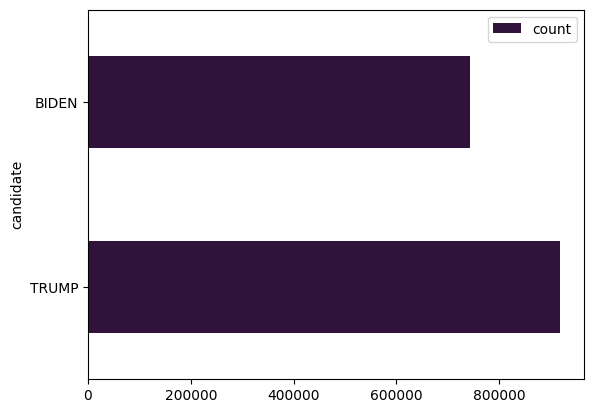

In [16]:
#Distribution of Trump and Biden tweets before data cleaning
df.createOrReplaceTempView("politicalTweets")
sparkSession.sql("""
    SELECT candidate, COUNT(candidate) as count
        FROM politicalTweets
        GROUP BY candidate
""").toPandas().plot(kind='barh', x='candidate', y='count', colormap='turbo')

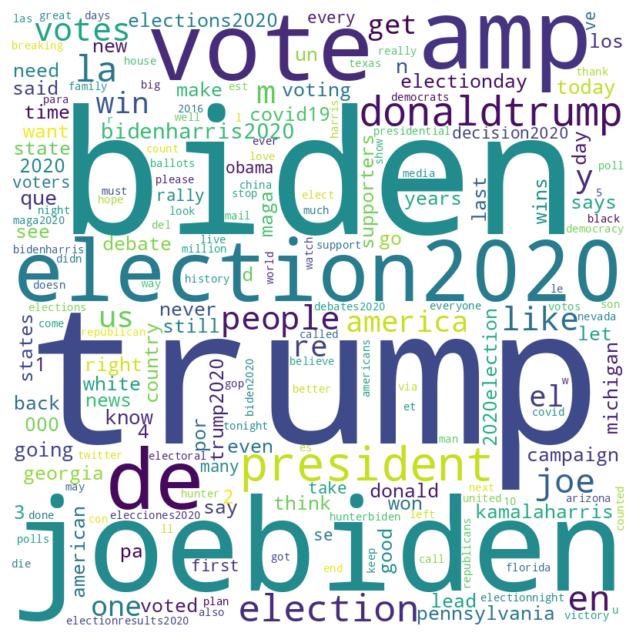

In [37]:
#Word cloud
class CleanTweet(Transformer):
    def __init__(self):
        super(CleanTweet, self).__init__()

    def _transform(self, df: DataFrame) -> DataFrame:
        # Drop null values
        df = df.dropna(subset=['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'user_followers_count', 'country', 'candidate'])

        # Filter tweets from USA
        df = df.filter((col("country").like('United States')) | (col("country").like('United States of America')))
        df = df.drop('country', 'continent')
        df = df.where(df.user_join_date < '2022-05-05')
        df = df.where(col('user_join_date').isNotNull())

        #Dropping non-relevant fields
        df = df.drop('user_name', 'user_screen_name', 'user_description')

        # Drop records that don't have at least 10 likes.
        df = df.where(col("likes") > constants.TwitterData.MIN_N_O_LIKES.value)

        # removal of URIs and Mentions
        df = df.withColumn('cleaned_tweet', clean_text(col('tweet'))) # Assuming clean_text function is defined somewhere
        return df

clean_tweet_transformer = CleanTweet()
cleaned_df = clean_tweet_transformer.transform(df)

# Tokenize the cleaned tweet text and remove numbers
tokenizer = RegexTokenizer(inputCol="cleaned_tweet", outputCol="words", pattern="[^\w]+")
df_tokenized = tokenizer.transform(cleaned_df)

# Removal of stop words
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_filtered = stop_words_remover.transform(df_tokenized)
df_exploded = df_filtered.select(explode("filtered_words").alias("word"))
word_counts = df_exploded.groupBy("word").count()
word_counts_pd = word_counts.toPandas()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(zip(word_counts_pd["word"], word_counts_pd["count"])))

# Plot the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
sparkSession.stop()